# Prognotisering av Bergen Bysykkel

In [268]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [269]:
# hadde noen gang problemer med å imporere pipeline

import importlib, train
importlib.reload(train)
from train import pipeline

In [270]:
seed = 42

## Del 1 - Datautforsking og dataklargjøring

### 1.1 Lese inn csv-filene

In [271]:
stations = pd.read_csv("raw_data/stations.csv")
trips = pd.read_csv("raw_data/trips.csv")
weather = pd.read_csv("raw_data/weather.csv")

### 1.2 Ser hva datasettene inneholder av kolonner

In [272]:
display(stations.head())
display(trips.head())
display(weather.head())

,station,longitude,latitude,timestamp,skipped_updates,free_bikes,free_spots
0,Gågaten,5.318798,60.395070,2024-10-26 13:09:58+00:00,6,7,3
1,Bjørnsonsgate,5.342082,60.373986,2025-03-16 10:23:21+00:00,11,0,19
2,Haukeland sykehus,5.356595,60.373638,2025-04-23 09:36:49+00:00,1,3,16
3,Krohnviken,5.331021,60.378107,2024-10-09 18:24:57+00:00,0,4,15
4,Nykirkekaien,5.314548,60.397057,2024-09-29 09:23:49+00:00,3,3,7


,started_at,ended_at,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude
0,2023-01-01 04:22:50.614000+00:00,2023-01-01 04:33:19.884000+00:00,Torget,60.395878,5.325284,Takhagen på Nordnes,60.398865,5.306411
1,2023-01-01 04:31:33.724000+00:00,2023-01-01 04:33:21.525000+00:00,Kong Oscars gate,60.393323,5.330654,Kong Oscars gate,60.393323,5.330654
2,2023-01-01 04:33:41.500000+00:00,2023-01-01 04:44:24.625000+00:00,Kong Oscars gate,60.393323,5.330654,Skutevikstorget,60.402229,5.320745
3,2023-01-01 05:55:30.388000+00:00,2023-01-01 05:59:17.644000+00:00,John Lunds plass,60.388247,5.324558,Skur 11,60.396384,5.324169
4,2023-01-01 05:59:33.946000+00:00,2023-01-01 06:03:47.999000+00:00,Skur 11,60.396384,5.324169,Hans Hauges gate,60.401906,5.324748


,timestamp,temperature,precipitation,wind_speed
0,2023-12-31 23:00:00+00:00,3.0,0.0,17.9
1,2024-01-01 00:00:00+00:00,2.8,0.0,13.2
2,2024-01-01 01:00:00+00:00,2.6,0.0,10.5
3,2024-01-01 02:00:00+00:00,2.7,0.0,18.9
4,2024-01-01 03:00:00+00:00,2.1,0.0,18.4


In [344]:
display(stations.describe())
display(trips.describe())
display(weather.describe())

,free_bikes
count,16077.000000
mean,7.669403
std,7.296786
min,0.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,34.000000


,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,952601.000000,952601.000000,952601.000000,952601.000000
mean,60.388004,5.327178,60.388331,5.326808
std,0.009795,0.012697,0.009445,0.012171
min,60.341031,5.273174,60.341031,5.273174
25%,60.381512,5.320002,60.382255,5.320656
50%,60.388910,5.325714,60.389626,5.325714
75%,60.394550,5.333327,60.394550,5.333027
max,60.423343,5.361202,60.423343,5.361202


,temperature,precipitation,wind_speed
count,11575.000000,11599.000000,11597.000000
mean,7.054609,0.318036,11.352358
std,6.521379,0.743150,7.161594
min,-16.000000,0.000000,0.000000
25%,2.900000,0.000000,5.600000
50%,6.900000,0.000000,9.900000
75%,11.400000,0.200000,15.700000
max,27.900000,9.600000,40.600000


#### 1.2.2 Ser hvor store datasettene er

In [273]:
print(f"Station: {stations.shape}")
print(f"Trips: {trips.shape}")
print(f"Weather: {weather.shape}")

Station: (289664, 7)
Trips: (952601, 8)
Weather: (11707, 4)


#### 1.2.3 Ser hvilken type data vi har

In [274]:
print(f"Station: \n{stations.dtypes}\n")
print(f"Trips: \n{trips.dtypes}\n")
print(f"Weather: \n{weather.dtypes}")

Station: 
station             object
longitude          float64
latitude           float64
timestamp           object
skipped_updates      int64
free_bikes           int64
free_spots           int64
dtype: object

Trips: 
started_at                  object
ended_at                    object
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
dtype: object

Weather: 
timestamp         object
temperature      float64
precipitation    float64
wind_speed       float64
dtype: object


### 1.3 Visualisering

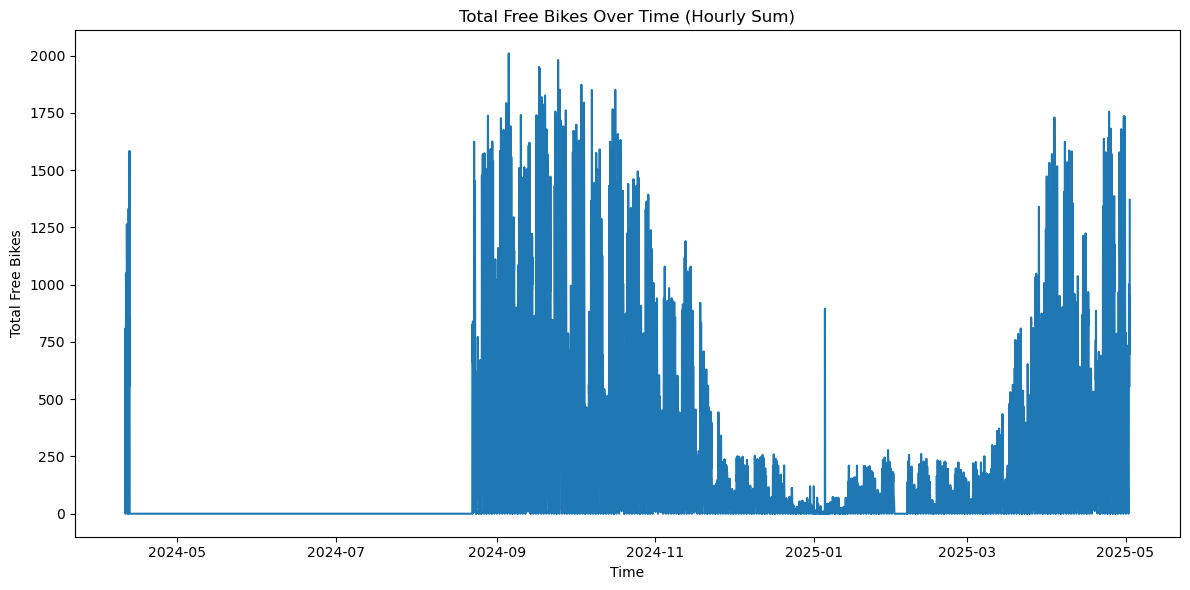

In [275]:
# visualiserer stations og viser hvor mange ledige sykler totalt over tid
stations['timestamp'] = pd.to_datetime(stations['timestamp'])

time_series_simple = stations.set_index('timestamp').resample('1h')['free_bikes'].sum()

plt.figure(figsize=(12,6))
plt.plot(time_series_simple.index, time_series_simple.values, color='tab:blue')
plt.title('Total Free Bikes Over Time (Hourly Sum)')
plt.xlabel('Time')
plt.ylabel('Total Free Bikes')
plt.tight_layout()
plt.show()

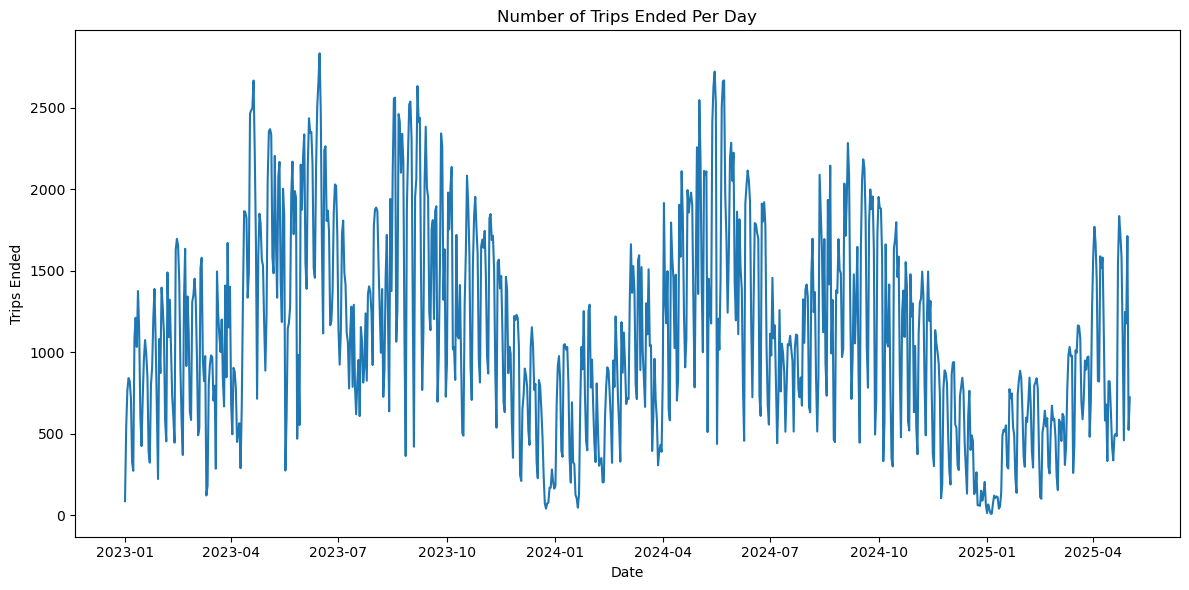

In [276]:
# visualiserer trips (per dag)
trips['ended_at'] = pd.to_datetime(trips['ended_at'], errors='coerce')

trips_per_day = trips.set_index('ended_at').resample('1D').size()

plt.figure(figsize=(12,6))
plt.plot(trips_per_day.index, trips_per_day.values, color='tab:blue')
plt.title('Number of Trips Ended Per Day')
plt.xlabel('Date')
plt.ylabel('Trips Ended')
plt.tight_layout()
plt.show()

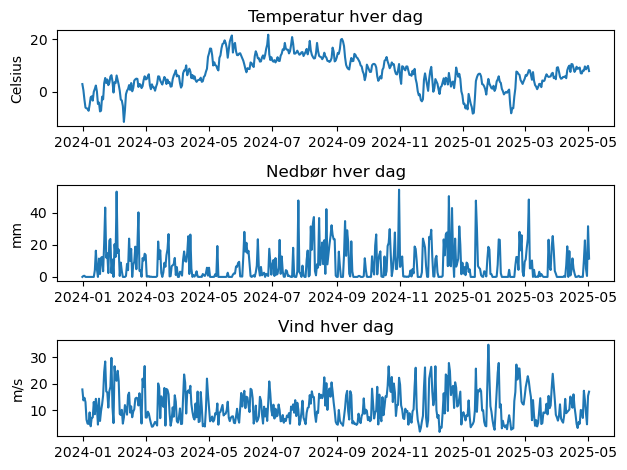

In [277]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
w = weather.set_index("timestamp").sort_index()

weather_daily = pd.DataFrame({

    "temperature": w["temperature"].resample("D").mean(),
    "precipitation": w["precipitation"].resample("D").sum(),
    "wind_speed": w["wind_speed"].resample("D").mean(),
})

fig, axes = plt.subplots(3, 1) 
axes[0].plot(weather_daily.index, weather_daily["temperature"], label="Temperatur (C)")
axes[1].plot(weather_daily.index, weather_daily["precipitation"], label="Precipitation")
axes[2].plot(weather_daily.index, weather_daily["wind_speed"], label="Wind speed")

axes[0].set_title("Temperatur hver dag")
axes[1].set_title("Nedbør hver dag")
axes[2].set_title("Vind hver dag")

axes[0].set_ylabel("Celsius")
axes[1].set_ylabel("mm")
axes[2].set_ylabel("m/s")

plt.tight_layout()
plt.show()

### 1.4 Fjerner hull i stations

Siden stations har et stort mellomrom uten data, må man fjerne dette før man deler inn.

In [278]:
stations_sorted = stations.sort_values("timestamp")
stations_sorted["gap"] = stations_sorted["timestamp"].diff()

largest_gap = stations_sorted["gap"].max()
print(largest_gap)

after_gap = stations_sorted.loc[stations_sorted["gap"] == largest_gap, "timestamp"].iloc[0]
print(after_gap)

stations_after_gap = stations_sorted[stations_sorted["timestamp"] > after_gap].copy()

132 days 00:00:02
2024-08-22 14:48:42+00:00


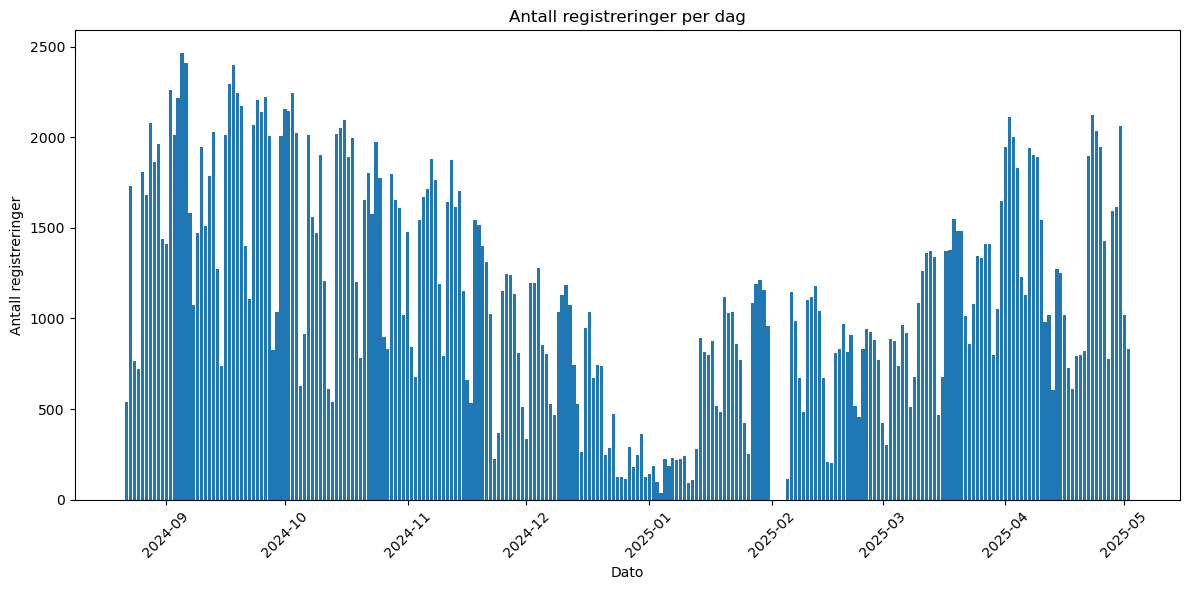

In [279]:
# viser stations etter fjerning av hull
stations_after_gap["timestamp"] = pd.to_datetime(stations_after_gap["timestamp"])

counts_per_day = stations_after_gap.set_index("timestamp").resample("d").size()

plt.figure(figsize=(12,6))
plt.bar(counts_per_day.index, counts_per_day.values, color='tab:blue')
plt.title('Antall registreringer per dag')
plt.xlabel('Dato')
plt.ylabel('Antall registreringer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5 Gjør om til tidspunkt og dato

In [280]:
stations["timestamp"] = pd.to_datetime(stations["timestamp"], errors="coerce", utc=True)
trips["started_at"] = pd.to_datetime(trips["started_at"], errors="coerce", utc=True)
trips["ended_at"] = pd.to_datetime(trips["ended_at"], errors="coerce", utc=True)
weather["timestamp"] = pd.to_datetime(weather["timestamp"], errors="coerce", utc=True)

### 1.6 Deler i train og test

Deler bare inn i to ettersom dette er dataanalysen. Skal dele inn i val senere i prosjektet. Ser aldri på test så det vil ikke påvirke senere.

Deler bare inn stations

In [281]:
stations_train, stations_test = train_test_split(stations_after_gap, test_size=0.3, shuffle=False)
trips_train, trips_test = train_test_split(trips, test_size=0.3, shuffle=False)
weather_train, weather_test = train_test_split(weather, test_size=0.3, shuffle=False)

### 1.7 Ser på datasettene

In [282]:
# form
print(f"Station train: {stations_train.shape}")
print(f"Trips train: {trips_train.shape}")
print(f"Weather train: {weather_train.shape}")

Station train: (200614, 8)
Trips train: (666820, 8)
Weather train: (8194, 4)


#### 1.7.2 Ser på første og siste observasjon

In [283]:
# ser her på hele datasettet
first_stations, last_stations = stations_after_gap["timestamp"].max(), stations_after_gap["timestamp"].min()
first_trips, last_trips = trips["started_at"].max(), trips["ended_at"].min()
first_weather, last_weather = weather["timestamp"].max(), weather["timestamp"].min()

print(f"Stations: \n{last_stations}\n{first_stations}\n")
print(f"Trips: \n{last_trips}\n{first_trips}\n")
print(f"Weather: \n{last_weather}\n{first_weather}")

Stations: 
2024-08-22 15:05:34+00:00
2025-05-02 15:49:25+00:00

Trips: 
2023-01-01 04:33:19.884000+00:00
2025-05-02 15:52:52.760000+00:00

Weather: 
2023-12-31 23:00:00+00:00
2025-05-02 16:00:00+00:00


#### 1.7.3 Sjekker manglende verdier

In [284]:
# sjekker for manglende verdier per kolonne

dfs = {
    "stations" : stations_train,
    "trips" : trips_train,
    "weather" : weather_train
}

for name, df in dfs.items():
    antall = df.isna().sum().sort_values(ascending=False)
    prosent = (antall / len(df) * 100).round(2)
    out = pd.DataFrame({"missing": antall, "percent": prosent})
    out = out[out["missing"] > 0]
    
    print(f"{name}:")
    if out.empty:
        print("Ingen verdier mangler")
    else:
        display(out)

stations:
Ingen verdier mangler
trips:


,missing,percent
started_at,695,0.1
ended_at,665,0.1


weather:


,missing,percent
temperature,90,1.10
wind_speed,83,1.01
precipitation,75,0.92


### 1.8 Trips og weather

#### 1.8.1 Lager total trips per time

Jeg vil bruke trips.csv til å se hvor mange turer det blir tatt totalt. Den sorterer hvor mange turer som blir tatt totalt hver time. Ene kolonnen viser timen, den andre viser antall turer. Dette går på alle stasjoner. Ved å gjøre dette om til turer per time, kan vi bruke det videre i det ferdige datasettet.

In [285]:
trips_train["hour"] = trips_train["started_at"].dt.ceil("h")
trips_per_hour = trips_train.groupby("hour").size().reset_index(name="total_trips")

trips_per_hour.head()

,hour,total_trips
0,2023-01-01 05:00:00+00:00,3
1,2023-01-01 06:00:00+00:00,2
2,2023-01-01 07:00:00+00:00,7
3,2023-01-01 08:00:00+00:00,4
4,2023-01-01 10:00:00+00:00,1


#### 1.8.2 Ser på hvor mange turer det er hver dag

In [286]:
# Lager om til antall per dag for å få en oversikt over når folk sykler mest
trips_train["date"] = trips_train["started_at"].dt.floor("d")
trips_per_day = trips_train.groupby("date").size().reset_index(name="total_trips")
trips_per_day.head()

,date,total_trips
0,2023-01-01 00:00:00+00:00,88
1,2023-01-02 00:00:00+00:00,541
2,2023-01-03 00:00:00+00:00,767
3,2023-01-04 00:00:00+00:00,845
4,2023-01-05 00:00:00+00:00,822


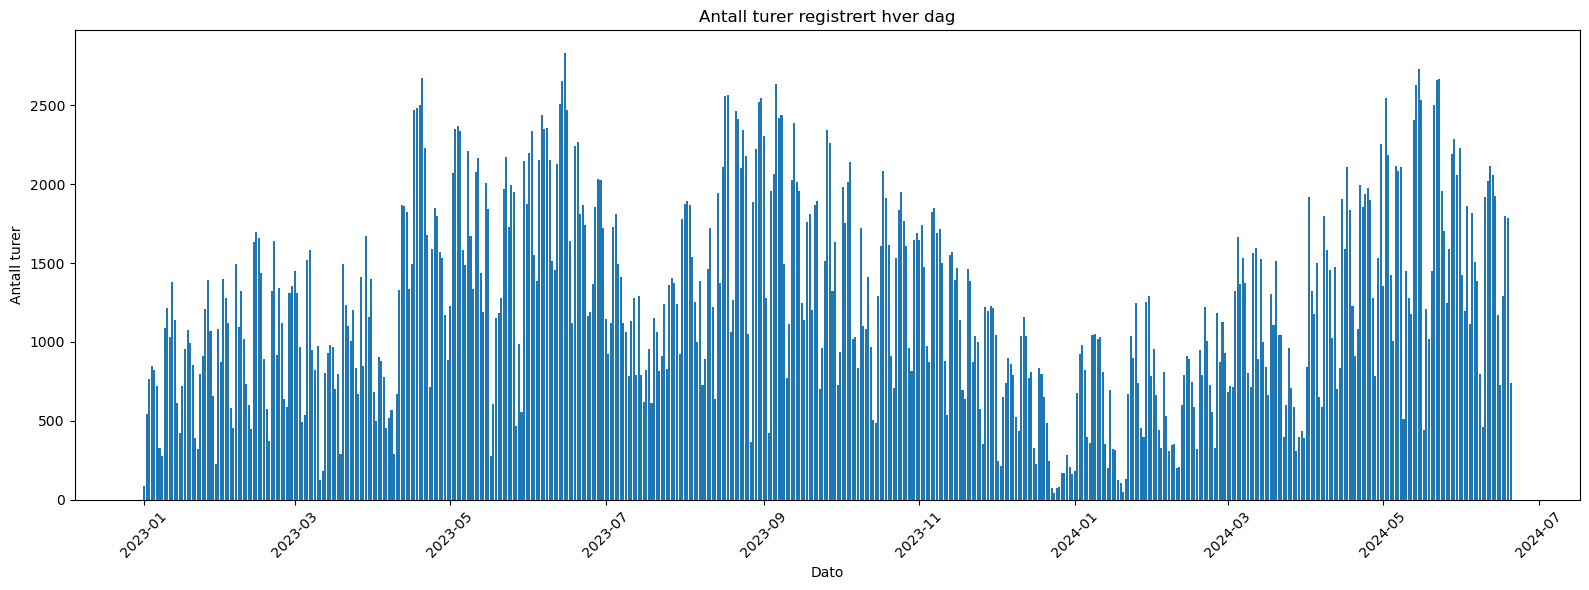

In [287]:
# liten visualisering av total_trips
plt.figure(figsize=(16,6))
plt.bar(trips_per_day["date"], trips_per_day["total_trips"], color="tab:blue")
plt.title("Antall turer registrert hver dag")
plt.xlabel("Dato")
plt.ylabel("Antall turer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [288]:
trips_train.head()

,started_at,ended_at,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,hour,date
0,2023-01-01 04:22:50.614000+00:00,2023-01-01 04:33:19.884000+00:00,Torget,60.395878,5.325284,Takhagen på Nordnes,60.398865,5.306411,2023-01-01 05:00:00+00:00,2023-01-01 00:00:00+00:00
1,2023-01-01 04:31:33.724000+00:00,2023-01-01 04:33:21.525000+00:00,Kong Oscars gate,60.393323,5.330654,Kong Oscars gate,60.393323,5.330654,2023-01-01 05:00:00+00:00,2023-01-01 00:00:00+00:00
2,2023-01-01 04:33:41.500000+00:00,2023-01-01 04:44:24.625000+00:00,Kong Oscars gate,60.393323,5.330654,Skutevikstorget,60.402229,5.320745,2023-01-01 05:00:00+00:00,2023-01-01 00:00:00+00:00
3,2023-01-01 05:55:30.388000+00:00,2023-01-01 05:59:17.644000+00:00,John Lunds plass,60.388247,5.324558,Skur 11,60.396384,5.324169,2023-01-01 06:00:00+00:00,2023-01-01 00:00:00+00:00
4,2023-01-01 05:59:33.946000+00:00,2023-01-01 06:03:47.999000+00:00,Skur 11,60.396384,5.324169,Hans Hauges gate,60.401906,5.324748,2023-01-01 06:00:00+00:00,2023-01-01 00:00:00+00:00


In [289]:
# viser gjennomsnittet for hvor mange sykler det er hver dag
trips_per_day["weekday"] = trips_per_day["date"].dt.weekday

dager = {0: 'Mandag', 1: 'Tirsdag', 2: 'Onsdag', 3: 'Torsdag', 4: 'Fredag', 5: 'Lørdag', 6: 'Søndag'}
trips_per_day["weekday_name"] = trips_per_day["weekday"].map(dager)

trips_by_weekday = trips_per_day.groupby("weekday_name")["total_trips"].mean().reset_index()

trips_by_weekday["weekday_name"] = pd.Categorical(trips_by_weekday["weekday_name"], categories=["Mandag", "Tirsdag", "Onsdag", "Torsdag", "Fredag", "Lørdag", "Søndag"], ordered=True)
trips_by_weekday = trips_by_weekday.sort_values("weekday_name")

fig = px.line(
    trips_by_weekday, x="weekday_name", y="total_trips",
    title="Gjennomsnittlig antall sykkelturer per ukedag",
    labels={"weekday_name": "Dag", "total_trips": "Antall turer"},
    width=900
)
fig.show()

#### 1.8.3 Lager en "hour" kolonne for weather

In [290]:
weather_train["hour"] = weather_train["timestamp"].dt.ceil("h")

weather_per_hour = (
    weather_train
    .groupby("hour")[["temperature", "precipitation", "wind_speed"]]
    .agg({
        "temperature" : "mean",
        "precipitation" : "sum",
        "wind_speed" : "mean"
    })
    .reset_index()
)

In [291]:
weather_per_hour.head()

,hour,temperature,precipitation,wind_speed
0,2023-12-31 23:00:00+00:00,3.0,0.0,17.9
1,2024-01-01 00:00:00+00:00,2.8,0.0,13.2
2,2024-01-01 01:00:00+00:00,2.6,0.0,10.5
3,2024-01-01 02:00:00+00:00,2.7,0.0,18.9
4,2024-01-01 03:00:00+00:00,2.1,0.0,18.4


#### 1.8.4 Sammenligning av weather og total_trips

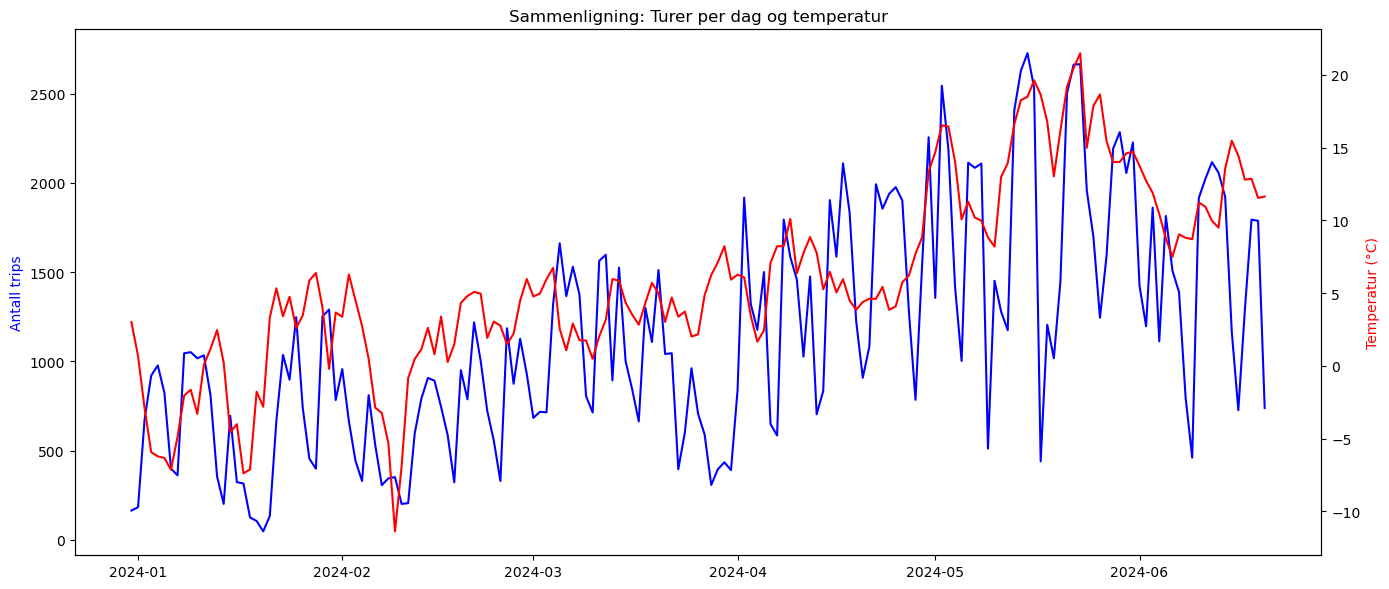

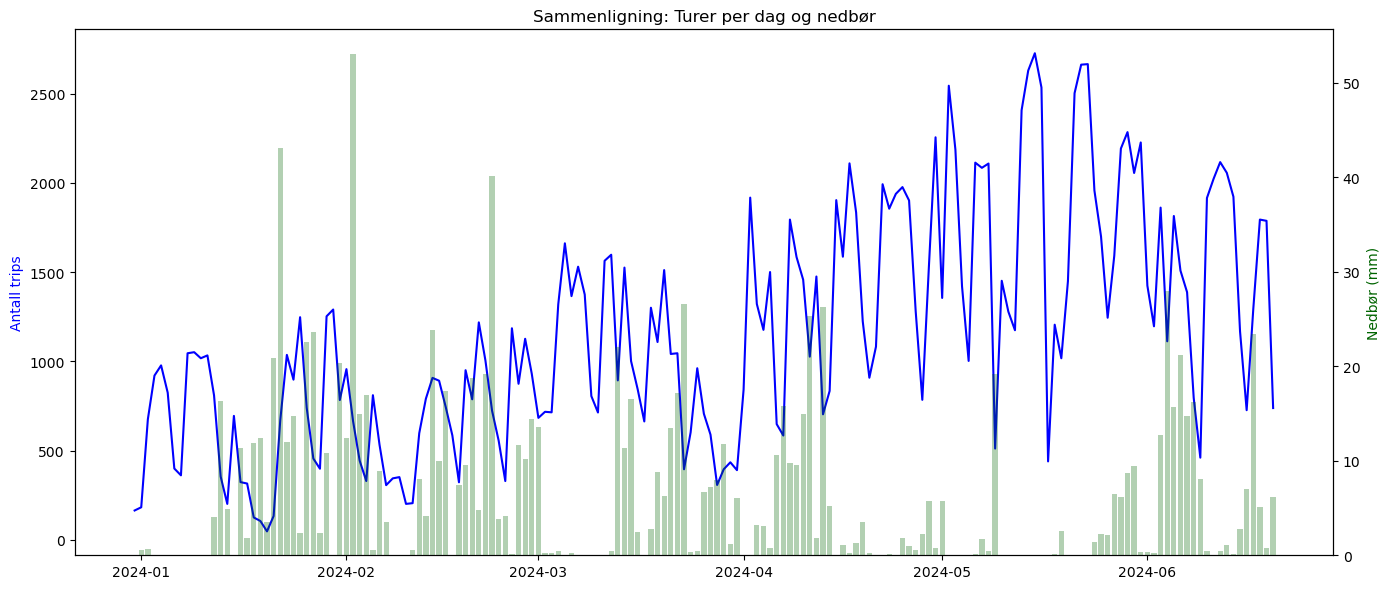

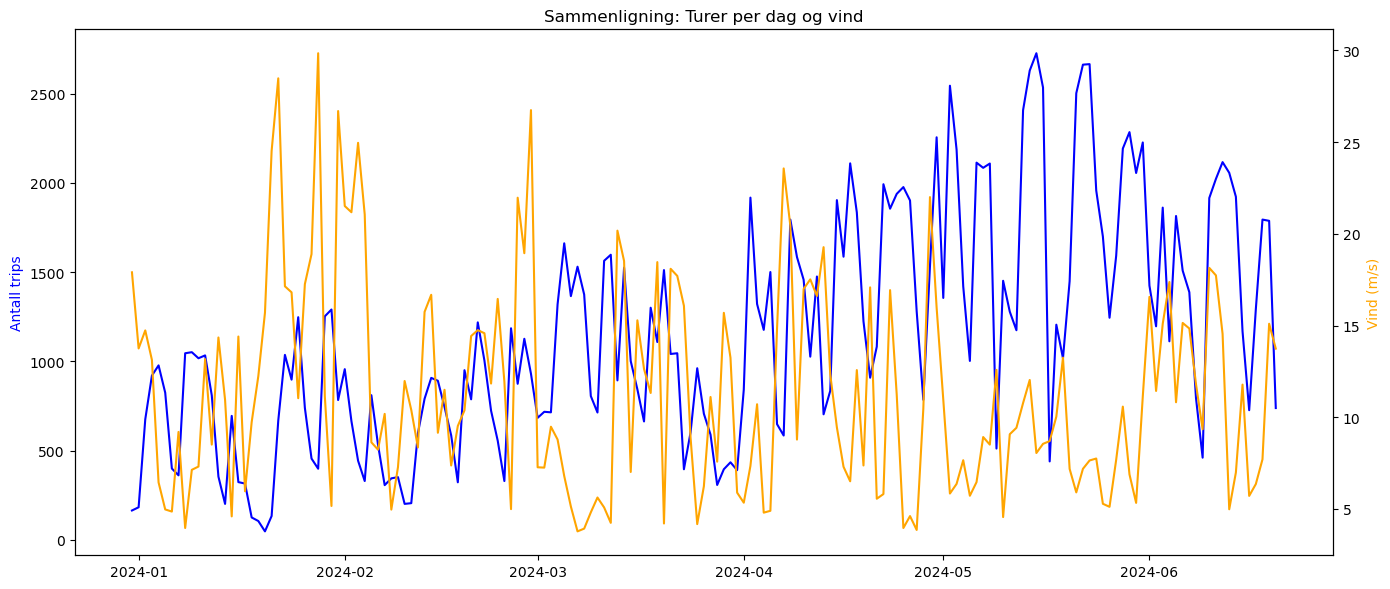

In [292]:
# temperatur og antall turer

weather_train["date"] = weather_train["timestamp"].dt.date
w_daily = weather_train.groupby("date").agg({
    "temperature" : "mean",
    "precipitation" : "sum",
    "wind_speed" : "mean"
}).reset_index()

trips_per_day["date"] = pd.to_datetime(trips_per_day["date"]).dt.tz_localize(None)
w_daily["date"] = pd.to_datetime(w_daily["date"])

merged = pd.merge(trips_per_day, w_daily, on="date", how="inner")

fig, ax1 = plt.subplots(figsize=(14,6))

# Figur 1 med turer og temperatur
ax1.plot(merged["date"], merged["total_trips"], color="blue", label="Trips per dag")
ax1.set_ylabel("Antall trips", color="blue")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["temperature"], color="red", label="Temperatur")
ax2.set_ylabel("Temperatur (°C)", color="red")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Sammenligning: Turer per dag og temperatur")
fig.tight_layout()
plt.show()

# Figur 2 med turer og nedbør
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(merged["date"], merged["total_trips"], color="blue", label="Trips per dag")
ax1.set_ylabel("Antall trips", color="blue")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.bar(merged["date"], merged["precipitation"], alpha=0.3, color="darkgreen", label="Nedbør")
ax2.set_ylabel("Nedbør (mm)", color="darkgreen")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Sammenligning: Turer per dag og nedbør")
fig.tight_layout()
plt.show()

# Figur 3 med turer og vind
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(merged["date"], merged["total_trips"], color="blue", label="Trips per dag")
ax1.set_ylabel("Antall trips", color="blue")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(merged["date"], merged["wind_speed"], color="orange", label="Vind")
ax2.set_ylabel("Vind (m/s)", color="orange")
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Sammenligning: Turer per dag og vind")
fig.tight_layout()
plt.show()

### 1.9 Stations

#### 1.9.1 Utvalgte stasjoner

In [293]:
utvalgte_stasjoner = [
    "Møllendalsplass",
    "Torgallmenningen",
    "Grieghallen",
    "Høyteknologisenteret",
    "Studentboligene",
    "Akvariet",
    "Damsgårdsveien 71",
    "Dreggsallmenningen Sør",
    "Florida Bybanestopp"
]

# bruker bare stasjonene vi ønsker
stations_filtered = stations_train[stations_train["station"].isin(utvalgte_stasjoner)].copy()

stations_filtered.shape

(29453, 8)

#### 1.9.2 Lager en hour kolonne

In [294]:
stations_filtered["hour"] = stations_filtered["timestamp"].dt.ceil("h")

In [295]:
stations_filtered.head()

,station,longitude,latitude,timestamp,skipped_updates,free_bikes,free_spots,gap,hour
202808,Florida Bybanestopp,5.332332,60.382255,2024-08-22 15:05:34+00:00,0,8,17,0 days,2024-08-22 16:00:00+00:00
227419,Møllendalsplass,5.352078,60.379895,2024-08-22 15:05:34+00:00,0,11,6,0 days,2024-08-22 16:00:00+00:00
209918,Akvariet,5.304686,60.399877,2024-08-22 15:05:34+00:00,0,8,10,0 days,2024-08-22 16:00:00+00:00
27983,Damsgårdsveien 71,5.323223,60.380263,2024-08-22 15:05:34+00:00,0,19,0,0 days,2024-08-22 16:00:00+00:00
261886,Møllendalsplass,5.352078,60.379895,2024-08-22 15:24:00+00:00,0,12,5,0 days,2024-08-22 16:00:00+00:00


In [296]:
stations_filtered.shape

(29453, 9)

#### 1.9.3 Lager en kolonne som lagrer tidspunktet for siste måling generelt

In [297]:
last_obs = (
    stations_filtered
    .sort_values('timestamp')
    .groupby('hour')['timestamp'].last()
    .reset_index(name='last_obs')
)

In [298]:
last_obs.head()

,hour,last_obs
0,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00
1,2024-08-22 17:00:00+00:00,2024-08-22 16:49:50+00:00
2,2024-08-22 18:00:00+00:00,2024-08-22 17:48:55+00:00
3,2024-08-22 19:00:00+00:00,2024-08-22 18:36:40+00:00
4,2024-08-22 20:00:00+00:00,2024-08-22 19:49:00+00:00


#### 1.9.4 En rad per time og en kolonne per stasjon med siste registrering i timen

In [299]:
stations_per_hour = (
    stations_filtered
    .sort_values("timestamp")
    .groupby(["hour", "station"])["free_bikes"]
    .last()
    .unstack()
    .add_suffix("_free_bikes")
    .reset_index()
)

In [300]:
stations_per_hour.head()

station,hour,Akvariet_free_bikes,Damsgårdsveien 71_free_bikes,Dreggsallmenningen Sør_free_bikes,Florida Bybanestopp_free_bikes,Grieghallen_free_bikes,Høyteknologisenteret_free_bikes,Møllendalsplass_free_bikes,Studentboligene_free_bikes,Torgallmenningen_free_bikes
0,2024-08-22 16:00:00+00:00,8.0,18.0,NaN,8.0,NaN,NaN,14.0,NaN,13.0
1,2024-08-22 17:00:00+00:00,7.0,15.0,NaN,11.0,9.0,NaN,15.0,14.0,10.0
2,2024-08-22 18:00:00+00:00,6.0,14.0,28.0,12.0,NaN,NaN,17.0,14.0,9.0
3,2024-08-22 19:00:00+00:00,7.0,13.0,25.0,8.0,10.0,9.0,NaN,14.0,NaN
4,2024-08-22 20:00:00+00:00,NaN,13.0,29.0,7.0,10.0,8.0,13.0,16.0,10.0


#### 1.9.5 Får en rad for hver stasjon hver time

In [301]:
# gjør at hver rad tilsvarer en stasjon per time
stations = stations_per_hour.melt(id_vars="hour", var_name="station", value_name="free_bikes")

# fjerner "_free_bikes"
stations["station"] = stations["station"].str.replace("_free_bikes", "", regex=False)

# bruker one-hot encoding for hver stasjon
stations_dummies = pd.get_dummies(stations["station"])

# slår sammen hour, station og free_bikes sammen med stations_dummies
stations = pd.concat([stations[["hour", "station", "free_bikes"]], stations_dummies], axis=1).sort_values(["hour", "station"]).reset_index(drop=True)

In [302]:
stations.head()

,hour,station,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen
0,2024-08-22 16:00:00+00:00,Akvariet,8.0,True,False,False,False,False,False,False,False,False
1,2024-08-22 16:00:00+00:00,Damsgårdsveien 71,18.0,False,True,False,False,False,False,False,False,False
2,2024-08-22 16:00:00+00:00,Dreggsallmenningen Sør,NaN,False,False,True,False,False,False,False,False,False
3,2024-08-22 16:00:00+00:00,Florida Bybanestopp,8.0,False,False,False,True,False,False,False,False,False
4,2024-08-22 16:00:00+00:00,Grieghallen,NaN,False,False,False,False,True,False,False,False,False


#### 1.9.6 Lager et grid som fyller inn alle timene

In [303]:
# full tidsramme
full_range = pd.date_range(start=stations["hour"].min(), end=stations["hour"].max(), freq="h")

stations_list = stations["station"].unique()

# får en rad per stasjon per time
full_grid = pd.DataFrame([(station, hour) for station in stations_list for hour in full_range], columns=["station", "hour"])

# slår sammen med datasettet
stations_expanded = full_grid.merge(stations, on=["station", "hour"], how="left")

In [304]:
stations_expanded.head()

,station,hour,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False
1,Akvariet,2024-08-22 17:00:00+00:00,7.0,True,False,False,False,False,False,False,False,False
2,Akvariet,2024-08-22 18:00:00+00:00,6.0,True,False,False,False,False,False,False,False,False
3,Akvariet,2024-08-22 19:00:00+00:00,7.0,True,False,False,False,False,False,False,False,False
4,Akvariet,2024-08-22 20:00:00+00:00,NaN,True,False,False,False,False,False,False,False,False


#### 1.9.7 Fyller inn manglende verdier

In [305]:
# hvilke kolonner som skal ffill
cols = stations_expanded.columns.difference(["station", "hour"])

# fyller manglende verdier for kolonnene
stations_expanded[cols] = stations_expanded.groupby("station")[cols].ffill()

# fikser rekkefølge
stations_expanded = stations_expanded.sort_values(["hour", "station"])

#### 1.9.8 Legger til last_obs i datasettet

In [306]:
final_stations = stations_expanded.merge(last_obs, on="hour", how="left")

In [307]:
final_stations.head()

,station,hour,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00
1,Damsgårdsveien 71,2024-08-22 16:00:00+00:00,18.0,False,True,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00
2,Dreggsallmenningen Sør,2024-08-22 16:00:00+00:00,NaN,False,False,True,False,False,False,False,False,False,2024-08-22 15:48:44+00:00
3,Florida Bybanestopp,2024-08-22 16:00:00+00:00,8.0,False,False,False,True,False,False,False,False,False,2024-08-22 15:48:44+00:00
4,Grieghallen,2024-08-22 16:00:00+00:00,NaN,False,False,False,False,True,False,False,False,False,2024-08-22 15:48:44+00:00


In [308]:
final_stations.shape

(38916, 13)

### 1.10 Slår sammen datasettene

In [309]:
# ser først på datasettene for å være sikker på at alle har "hour"
display(final_stations.head(0))
display(trips_per_hour.head(0))
display(weather_per_hour.head(0))

,station,hour,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs


,hour,total_trips


,hour,temperature,precipitation,wind_speed


In [310]:
stations_and_trips = final_stations.merge(trips_per_hour[["hour", "total_trips"]], on="hour", how="left")
stations_and_trips["total_trips"] = stations_and_trips["total_trips"].astype("Int64")

stations_and_trips.head()

,station,hour,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs,total_trips
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>
1,Damsgårdsveien 71,2024-08-22 16:00:00+00:00,18.0,False,True,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>
2,Dreggsallmenningen Sør,2024-08-22 16:00:00+00:00,NaN,False,False,True,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>
3,Florida Bybanestopp,2024-08-22 16:00:00+00:00,8.0,False,False,False,True,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>
4,Grieghallen,2024-08-22 16:00:00+00:00,NaN,False,False,False,False,True,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>


In [311]:
merged = stations_and_trips.merge(weather_per_hour, on="hour", how="left")

merged.head()

,station,hour,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs,total_trips,temperature,precipitation,wind_speed
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
1,Damsgårdsveien 71,2024-08-22 16:00:00+00:00,18.0,False,True,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
2,Dreggsallmenningen Sør,2024-08-22 16:00:00+00:00,NaN,False,False,True,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
3,Florida Bybanestopp,2024-08-22 16:00:00+00:00,8.0,False,False,False,True,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
4,Grieghallen,2024-08-22 16:00:00+00:00,NaN,False,False,False,False,True,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4


#### 1.10.2 Legger til ekstra kolonner

In [312]:
# endrer først navnet på "hour" kolonnen tilbake til "timestamp"
merged.rename(columns={"hour": "timestamp"}, inplace=True)

In [313]:
merged.head()

,station,timestamp,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs,total_trips,temperature,precipitation,wind_speed
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
1,Damsgårdsveien 71,2024-08-22 16:00:00+00:00,18.0,False,True,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
2,Dreggsallmenningen Sør,2024-08-22 16:00:00+00:00,NaN,False,False,True,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
3,Florida Bybanestopp,2024-08-22 16:00:00+00:00,8.0,False,False,False,True,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4
4,Grieghallen,2024-08-22 16:00:00+00:00,NaN,False,False,False,False,True,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4


In [314]:
merged["hour"] = merged["timestamp"].dt.hour
merged["day_of_week"] = merged["timestamp"].dt.day_of_week
merged["month"] = merged["timestamp"].dt.month

In [315]:
merged.head()

,station,timestamp,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,Florida Bybanestopp,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,last_obs,total_trips,temperature,precipitation,wind_speed,hour,day_of_week,month
0,Akvariet,2024-08-22 16:00:00+00:00,8.0,True,False,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4,16,3,8
1,Damsgårdsveien 71,2024-08-22 16:00:00+00:00,18.0,False,True,False,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4,16,3,8
2,Dreggsallmenningen Sør,2024-08-22 16:00:00+00:00,NaN,False,False,True,False,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4,16,3,8
3,Florida Bybanestopp,2024-08-22 16:00:00+00:00,8.0,False,False,False,True,False,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4,16,3,8
4,Grieghallen,2024-08-22 16:00:00+00:00,NaN,False,False,False,False,True,False,False,False,False,2024-08-22 15:48:44+00:00,<NA>,14.0,4.0,16.4,16,3,8


#### 1.10.3 Lager Target kolonnen

In [316]:
merged["target"] = merged.groupby("station", observed=True)["free_bikes"].shift(-1)

### 1.11 Diverse

#### 1.11.1 Gjør om slik at det ikke er negative verdier

In [317]:
# sjekker hva som er den laveste
lowest_temp = merged["temperature"].min()
print(lowest_temp)

-5.9


In [318]:
# forskyver
merged["temperature_shifted"] = merged["temperature"] - lowest_temp

#### 1.11.2 Rydder i kolonner

In [319]:
# rekkefølge på kolonner:
merged = merged[[
    "timestamp",
    "last_obs",
    "hour", 
    "day_of_week",
    "month", 
    "station",
    "free_bikes",
    "Akvariet", 
    "Damsgårdsveien 71", 
    "Dreggsallmenningen Sør", 
    "Florida Bybanestopp", 
    "Grieghallen", 
    "Høyteknologisenteret", 
    "Møllendalsplass", 
    "Studentboligene", 
    "Torgallmenningen", 
    "precipitation", 
    "wind_speed", 
    "temperature_shifted", 
    "total_trips", 
    "target"
]].copy()

In [320]:
merged.head()

,timestamp,last_obs,hour,day_of_week,month,station,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,...,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,precipitation,wind_speed,temperature_shifted,total_trips,target
0,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00,16,3,8,Akvariet,8.0,True,False,False,...,False,False,False,False,False,4.0,16.4,19.9,<NA>,7.0
1,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00,16,3,8,Damsgårdsveien 71,18.0,False,True,False,...,False,False,False,False,False,4.0,16.4,19.9,<NA>,15.0
2,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00,16,3,8,Dreggsallmenningen Sør,NaN,False,False,True,...,False,False,False,False,False,4.0,16.4,19.9,<NA>,NaN
3,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00,16,3,8,Florida Bybanestopp,8.0,False,False,False,...,False,False,False,False,False,4.0,16.4,19.9,<NA>,11.0
4,2024-08-22 16:00:00+00:00,2024-08-22 15:48:44+00:00,16,3,8,Grieghallen,NaN,False,False,False,...,True,False,False,False,False,4.0,16.4,19.9,<NA>,9.0


### 1.12 Manglende data

#### 1.12.1 Sjekker for tomme variable

In [321]:
merged.isna().sum()

timestamp                     0
last_obs                  10764
hour                          0
day_of_week                   0
month                         0
station                       0
free_bikes                    7
Akvariet                      0
Damsgårdsveien 71             0
Dreggsallmenningen Sør        0
Florida Bybanestopp           0
Grieghallen                   0
Høyteknologisenteret          0
Møllendalsplass               0
Studentboligene               0
Torgallmenningen              0
precipitation             15876
wind_speed                16119
temperature_shifted       16119
total_trips               38916
target                       12
dtype: int64

#### 1.12.2 total_trips

Det er naturlig at f.eks. det ikke er turer midt på natten som gjør at det er manglende verdier. Det er derfor naturlig at disse blir fylt med 0.

In [322]:
merged["total_trips"] = merged["total_trips"].fillna(0)

#### 1.12.3 last_obs

In [323]:
merged["last_obs"] = merged["last_obs"].ffill()

#### 1.12.4 precipitation

In [324]:
merged["precipitation"] = merged["precipitation"].fillna(0)

#### 1.12.5 wind_speed og temperature_shifted

In [325]:
merged["wind_speed"] = merged["wind_speed"].ffill()
merged["temperature_shifted"] = merged["temperature_shifted"].ffill()

In [326]:
merged.isna().sum()

timestamp                  0
last_obs                   0
hour                       0
day_of_week                0
month                      0
station                    0
free_bikes                 7
Akvariet                   0
Damsgårdsveien 71          0
Dreggsallmenningen Sør     0
Florida Bybanestopp        0
Grieghallen                0
Høyteknologisenteret       0
Møllendalsplass            0
Studentboligene            0
Torgallmenningen           0
precipitation              0
wind_speed                 0
temperature_shifted        0
total_trips                0
target                    12
dtype: int64

## Del 2: Modellering og prediksjon

### 2.1 Bruker train.py for å hente datasettene

Her henter jeg fra train.py for å teste på det faktiske datasettet.

In [327]:
# før pipeline må fullet i stations fjernes
stations_data = pd.read_csv("raw_data/stations.csv")
stations_data["timestamp"] = pd.to_datetime(stations_data["timestamp"], errors="coerce", utc=True)
stations_sorted = stations_data.sort_values("timestamp")
stations_sorted["gap"] = stations_sorted["timestamp"].diff()

largest_gap = stations_sorted["gap"].max()

after_gap = stations_sorted.loc[stations_sorted["gap"] == largest_gap, "timestamp"].iloc[0]

stations_data_after = stations_sorted[stations_sorted["timestamp"] > after_gap].copy()

In [328]:
# deler inn i train, val og test før man sender videre til pipeliine
s_train, s_split = train_test_split(stations_data_after, test_size=0.3, shuffle=False)
s_val, s_test = train_test_split(s_split, test_size=0.5, shuffle=False)

#### 2.1.2 Henter fra train.py

In [329]:
# får ut det ferdige datasettet
df_train = pipeline(s_train)
df_val = pipeline(s_val)
df_test = pipeline(s_test)

In [330]:
df_test.tail(20)

,timestamp,last_obs,hour,day_of_week,month,station,free_bikes,Akvariet,Damsgårdsveien 71,Dreggsallmenningen Sør,...,Grieghallen,Høyteknologisenteret,Møllendalsplass,Studentboligene,Torgallmenningen,precipitation,wind_speed,temperature_shifted,total_trips,target
6640,2025-05-02 16:00:00+02:00,2025-05-02 15:49:07+02:00,16,4,5,Studentboligene,13.0,False,False,False,...,False,False,False,True,False,1.4,17.6,9.6,120,15.0
6641,2025-05-02 16:00:00+02:00,2025-05-02 15:49:07+02:00,16,4,5,Torgallmenningen,15.0,False,False,False,...,False,False,False,False,True,1.4,17.6,9.6,120,14.0
6642,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Akvariet,1.0,True,False,False,...,False,False,False,False,False,0.1,16.6,9.8,124,0.0
6643,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Damsgårdsveien 71,13.0,False,True,False,...,False,False,False,False,False,0.1,16.6,9.8,124,13.0
6644,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Dreggsallmenningen Sør,0.0,False,False,True,...,False,False,False,False,False,0.1,16.6,9.8,124,17.0
6645,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Florida Bybanestopp,20.0,False,False,False,...,False,False,False,False,False,0.1,16.6,9.8,124,21.0
6646,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Grieghallen,16.0,False,False,False,...,True,False,False,False,False,0.1,16.6,9.8,124,16.0
6647,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Høyteknologisenteret,24.0,False,False,False,...,False,True,False,False,False,0.1,16.6,9.8,124,24.0
6648,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Møllendalsplass,5.0,False,False,False,...,False,False,True,False,False,0.1,16.6,9.8,124,4.0
6649,2025-05-02 17:00:00+02:00,2025-05-02 16:47:17+02:00,17,4,5,Studentboligene,15.0,False,False,False,...,False,False,False,True,False,0.1,16.6,9.8,124,8.0


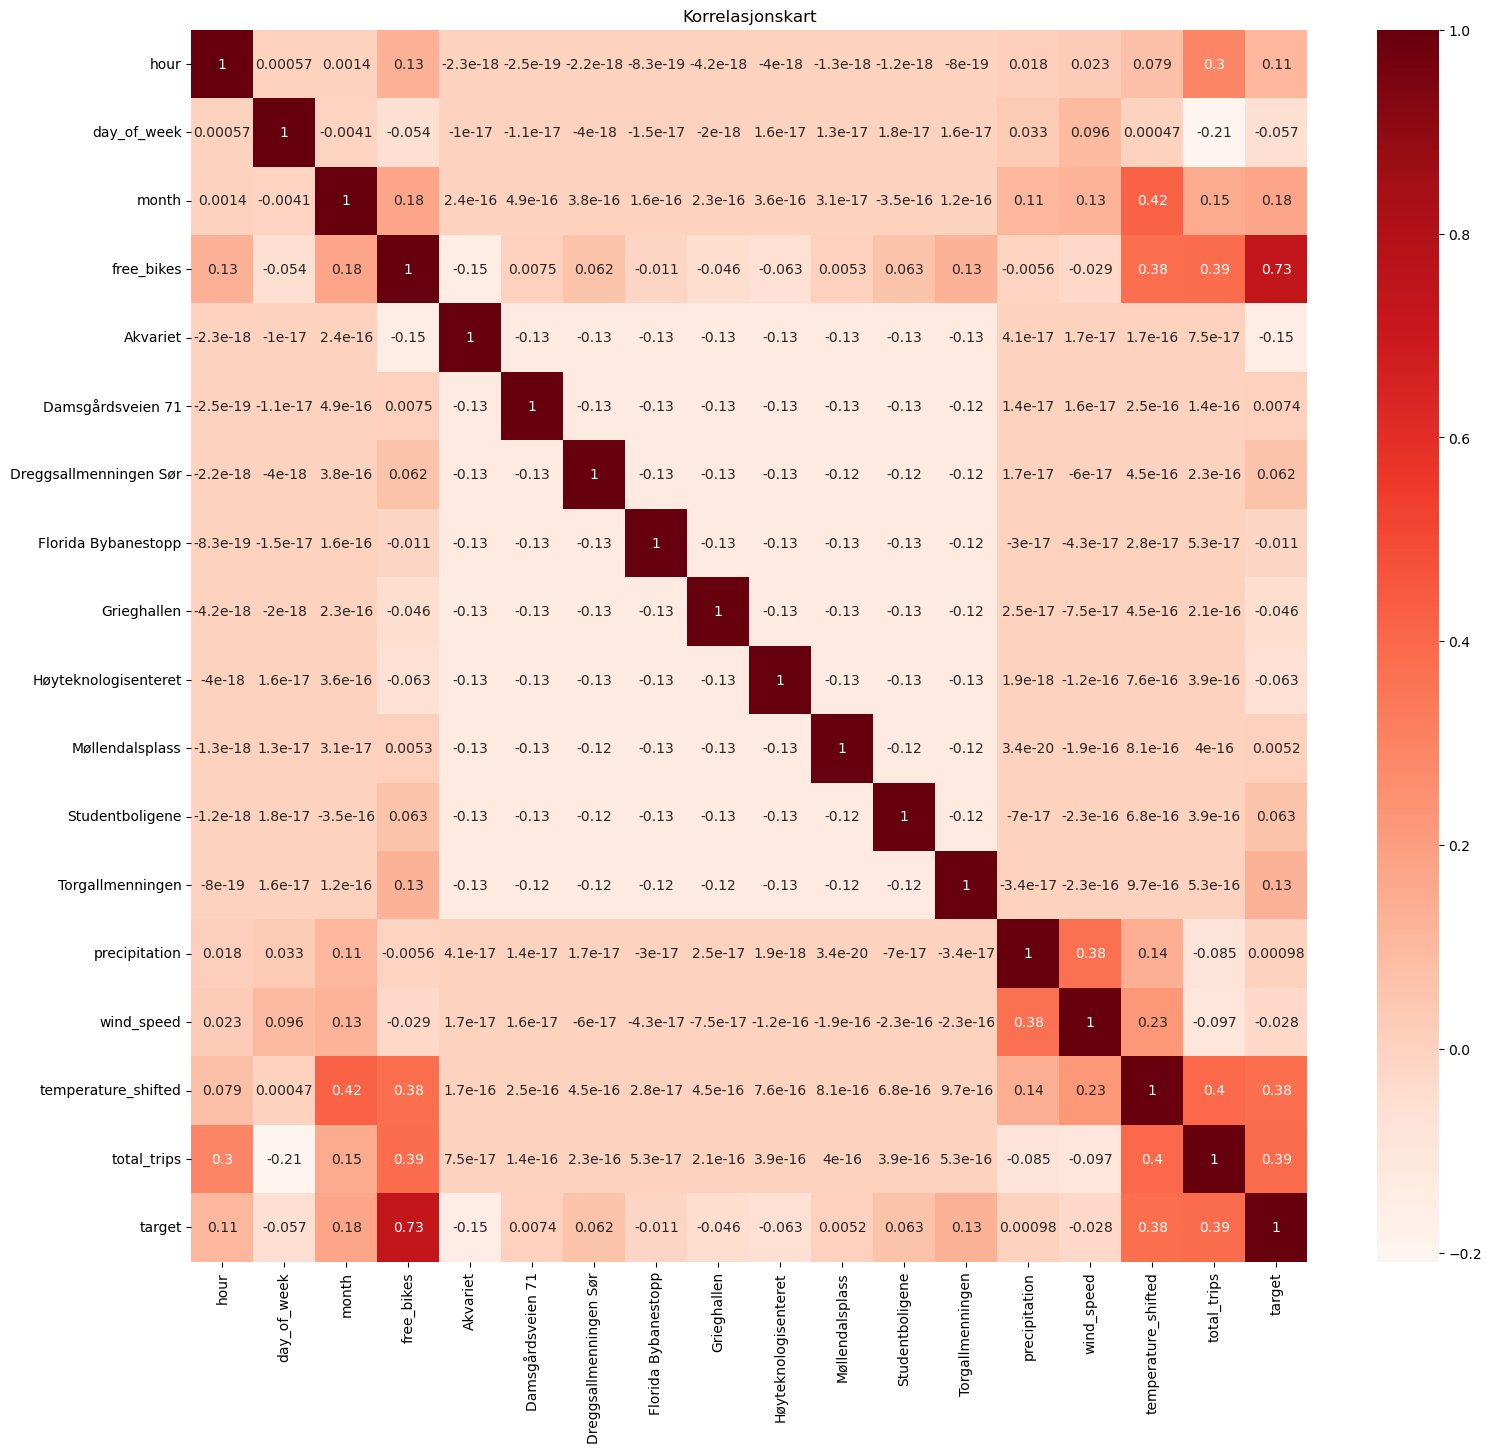

In [331]:
df = df_train.drop(columns=(["timestamp", "last_obs", "station"]))
cm = df.corr()

plt.figure(figsize=(18, 16))

sns.heatmap(cm, annot=True, cmap="Reds")

plt.title("Korrelasjonskart")
plt.show()

#### 2.1.3 Ser om target og antall ledige sykler stemmer 

Her ser jeg bare på en enkelt stasjon (Akvariet) for å gjøre det enklere å tolke. 

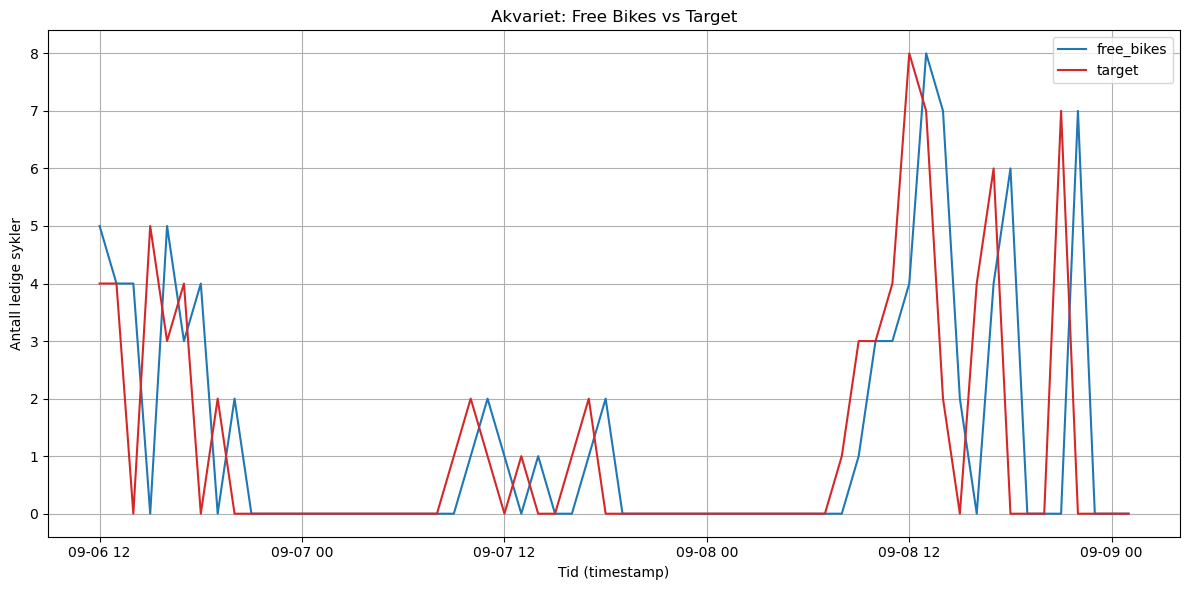

In [332]:
from matplotlib import pyplot as plt

akvarier_df = df_train[(df_train["Akvariet"] == True) & (df_train["timestamp"] >= "2024-09-06 10:00:00+00:00") &
    (df_train["timestamp"] <= "2024-09-08 23:59:59+00:00")].copy()

plt.figure(figsize=(12, 6))

plt.plot(
    akvarier_df["timestamp"],
    akvarier_df["free_bikes"],
    label="free_bikes",
    color="tab:blue"
)

plt.plot(
    akvarier_df["timestamp"],
    akvarier_df["target"],
    label="target",
    color="tab:red"
)

plt.title("Akvariet: Free Bikes vs Target")
plt.xlabel("Tid (timestamp)")
plt.ylabel("Antall ledige sykler")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2.1.4 Lager til X og y

In [333]:
df_train = df_train.dropna(subset=["target"])
df_val = df_val.dropna(subset=["target"])
df_test = df_test.dropna(subset=["target"])

In [334]:
X_train, y_train = df_train.drop(columns=(["timestamp", "last_obs", "target", "station"])), df_train["target"]
X_val, y_val = df_val.drop(columns=(["timestamp", "last_obs", "target", "station"])), df_val["target"]
X_test, y_test = df_test.drop(columns=(["timestamp", "last_obs", "target", "station"])), df_test["target"]

In [335]:
for name, X, y in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
    print(f"{name}: {X.shape}, y: {y.shape}")

train: (38907, 17), y: (38907,)
val: (9090, 17), y: (9090,)
test: (6651, 17), y: (6651,)


### Tester ut variabler

In [339]:
# lager en ny X_train uten de aktuelle kolonnene
X_train_drop = X_train.drop(columns=["hour", "day_of_week", "precipitation", "wind_speed"])
X_val_drop = X_val.drop(columns=["hour", "day_of_week", "precipitation", "wind_speed"])

In [340]:
# den beste modellen med uendrett data
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)
rmse_score_vanlig_train = root_mean_squared_error(y_train, best_model.predict(X_train))
rmse_score_vanlig_val = root_mean_squared_error(y_val, best_model.predict(X_val))
print(f"Uten endring: RMSE train = {rmse_score_vanlig_train}")
print(f"Uten endring: RMSE val = {rmse_score_vanlig_val}")

Uten endring: RMSE train = 1.3747597457733152
Uten endring: RMSE val = 2.731139584924805


In [341]:
# den beste modellen testet uten de aktuelle kolonnene
best_model_endret = RandomForestRegressor(random_state=42)
best_model_endret.fit(X_train_drop, y_train)
rmse_score_endret_train = root_mean_squared_error(y_train, best_model_endret.predict(X_train_drop))
rmse_score_endret_val = root_mean_squared_error(y_val, best_model_endret.predict(X_val_drop))
print(f"Med endring: RMSE train = {rmse_score_endret_train}")
print(f"Med endring: RMSE val = {rmse_score_endret_val}")

Med endring: RMSE train = 1.5440196743349284
Med endring: RMSE val = 2.8029864575090615


### Sjekker feature importances

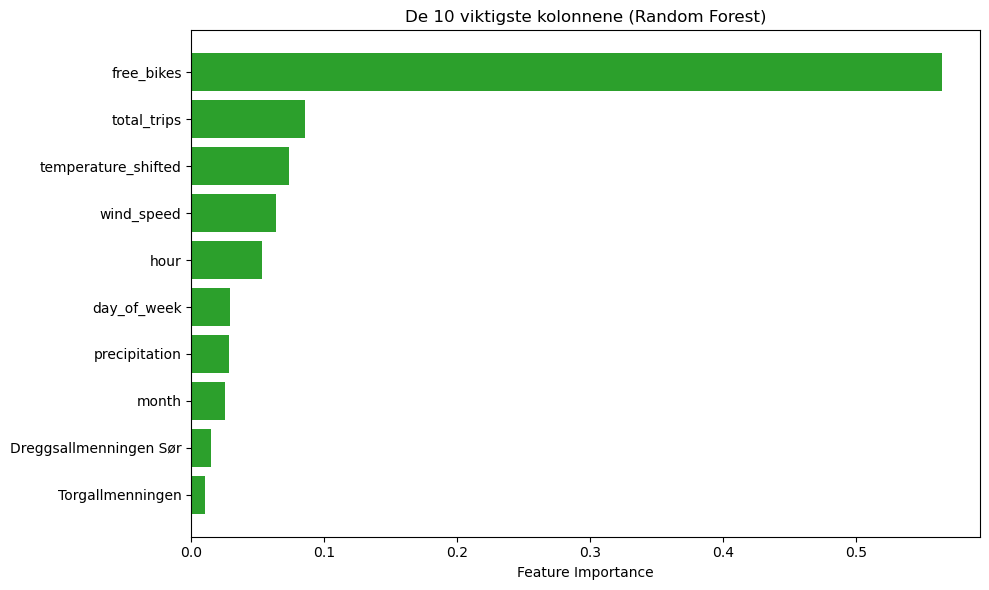

In [342]:
importances = pd.DataFrame({
    "Feature" : X_train.columns,
    "Importance" : best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"].head(10), importances["Importance"].head(10), color="tab:green")
plt.gca().invert_yaxis()
plt.title("De 10 viktigste kolonnene (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

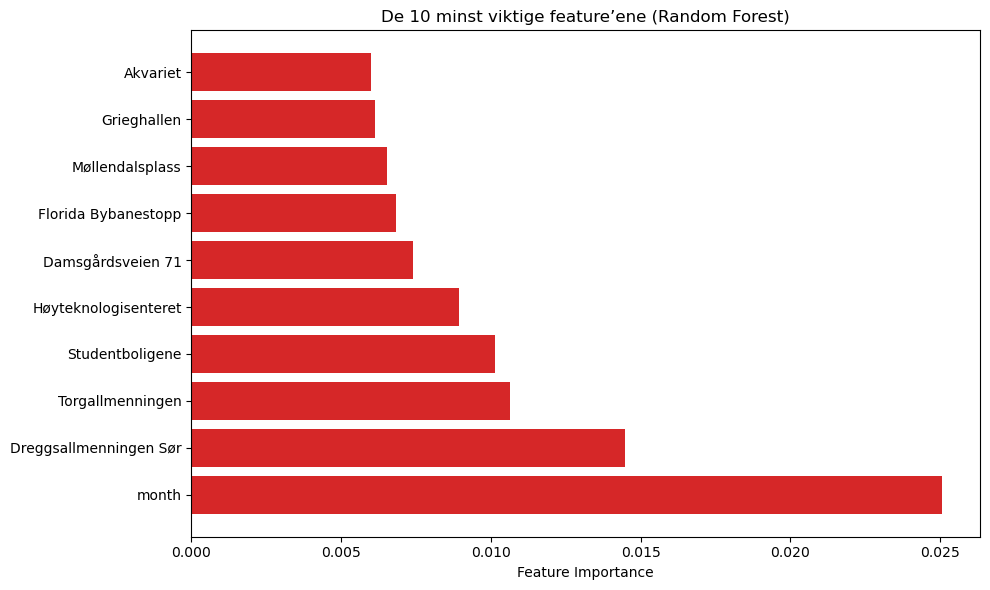

In [343]:
plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"].tail(10), importances["Importance"].tail(10), color="tab:red")
plt.title("De 10 minst viktige feature’ene (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()